# Exercise 6: AR-GARCH models

**_Group: Ducray, Razanajatovo_**

Please find below our code and empirical work regarding Apple's price returns. To fit the AR+GARCH model, we will fit first the AR(p) model and then applying the GARCH model to the residuals. The final prediction will be the sum of the ARIMA forecast + the GARCH forecasts.

In [1]:
# Dataframe, maths and plotting libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import t

from statsmodels.tsa.stattools import adfuller
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

!pip install arch
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
#============== Load and prepare data ================

    # Import data
df = pd.read_excel('AAPL.xlsx',index_col=0)
    # Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
    # Compute the daily log returns on Apple stock prices
df_logret = np.log(df['Adj Close'].iloc[1:]).diff().dropna()*100
df_logret

Date
2018-01-04    0.463434
2018-01-05    1.132100
2018-01-08   -0.372141
2018-01-09   -0.011468
2018-01-10   -0.022950
                ...   
2022-12-15   -4.798752
2022-12-16   -1.468611
2022-12-19   -1.603751
2022-12-20   -0.052890
2022-12-21    2.353045
Name: Adj Close, Length: 1251, dtype: float64

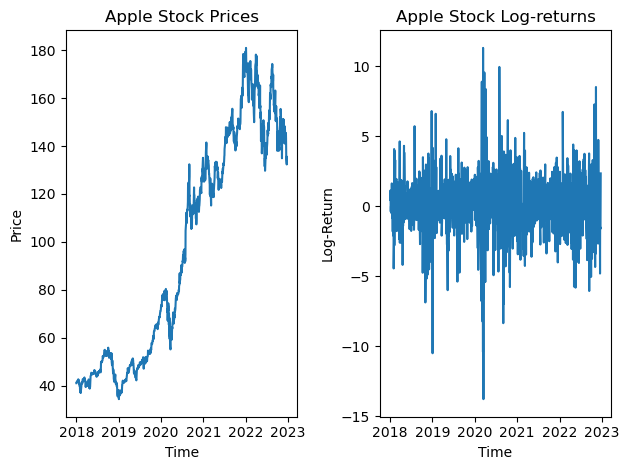

In [3]:
#================== Visual representation ===================

# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Adj Close'])
plt.title("Apple Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Apple Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## 1. Checking the stationarity with the Augmented Dickey Fuller test

In [4]:
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-11.082035
p-value,0.0
Lags Used,8
Number of Observations Used,1242
Critical Value(1%),-3.435626
Critical Value(5%),-2.86387
Critical Value(10%),-2.56801


The null hypothesis is rejected: the process is **stationary** (pvalue below thresholds & t-stat < critical value)
No need to differentiate or detrend

## 2. Fitting AR and GARCH models

Splitting dataset in train (in-sample, i.e. from 01/01/2018 to 31/08/2022) and test(out-sample, i.e. from 01/09/2022 to 21/12/2022):

In [5]:
df_train = df_logret.loc['2018-01-04':'2022-08-31' ]
df_test = df_logret.loc['2022-09-01':'2022-12-21']

### Choosing the order for AR part:

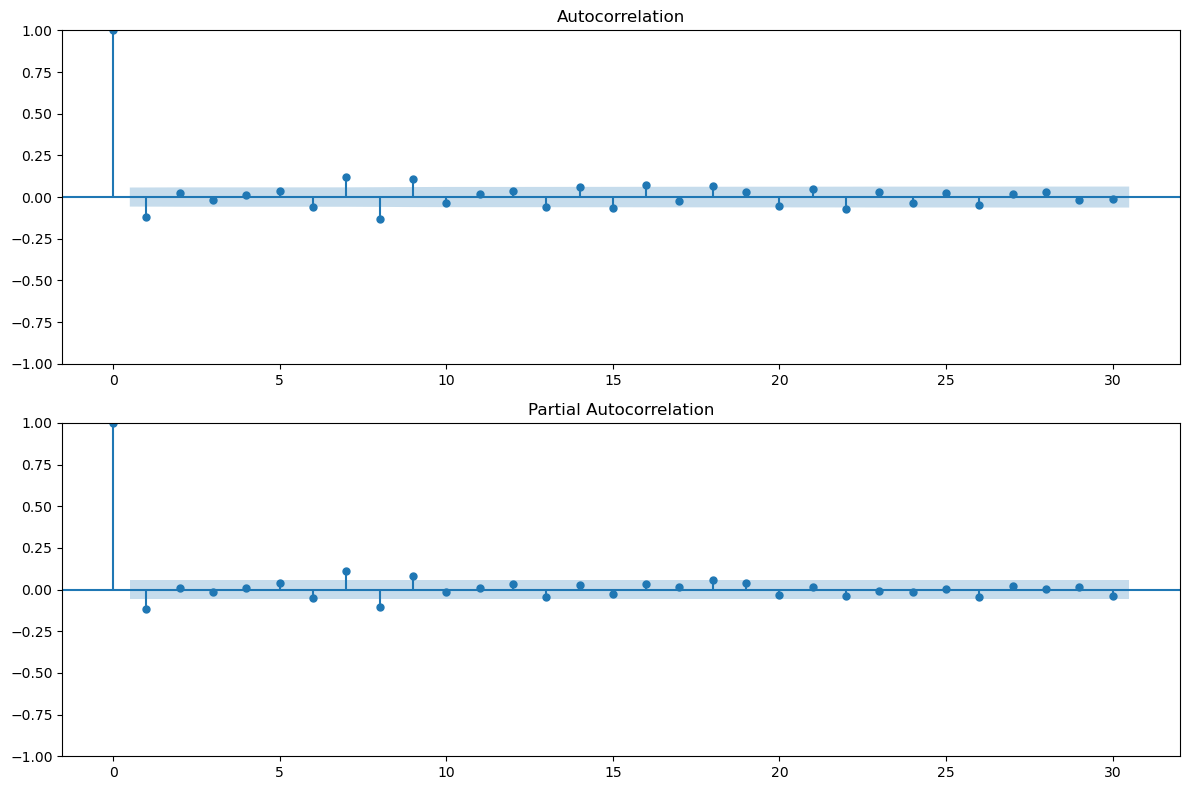

In [6]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=30, ax=ax2)
plt.tight_layout()

Graphically, we can't conclude about the exponential decay of the ACF but we can see a spike at order 1 on the PACF. We will use AIC and BIC criterion to confirm the optimal parameters:

**Paul: exponential decay or geometrical?**

In [7]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ma_order = [0]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, 0)).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:1 - ma:0
fitting: ar:2 - ma:0
fitting: ar:3 - ma:0
fitting: ar:4 - ma:0
fitting: ar:5 - ma:0
fitting: ar:6 - ma:0
fitting: ar:7 - ma:0
fitting: ar:8 - ma:0
fitting: ar:9 - ma:0
fitting: ar:10 - ma:0
criterion
     ar_order  ma_order       aic       bic
0          0         0  5.053090  5.063224
1          1         0  5.038805  5.054007
2          2         0  5.040738  5.061007
3          3         0  5.042510  5.067846
4          4         0  5.044367  5.074771
5          5         0  5.044317  5.079789
6          6         0  5.043284  5.083823
7          7         0  5.030840  5.076446
8          8         0  5.020024  5.070697
9          9         0  5.014500  5.070241
10        10         0  5.016271  5.077079


In [8]:
#========= confirming order chosen ============
sm.tsa.arma_order_select_ic(df_train,max_ar=10,max_ma=0,ic='bic')['bic_min_order']

(1, 0)

**The order chosen is thus an AR(1) to fit the data**

### Detecting the GARCH effect:

First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [9]:
#===== Analyze for GARCH effects using the Jarque-Bera test on the standardized residuals =======================

# Compute standardized residuals
df_train_std = (df_train - np.mean(df_train))/ np.std(df_train)
nb_obs = len(df_train_std)

# Run the Jarque-Bera test on standardized residuals
jb = sm.stats.stattools.jarque_bera(df_train_std, axis=0)
df_jb = pd.DataFrame(index=['T-stat', "P-value", "Skewness", "Kurtosis"],columns=['Output'])
df_jb['Output']['T-stat'] = jb[0]
df_jb['Output']['P-value'] = jb[1]
df_jb['Output']['Skewness'] = jb[2]
df_jb['Output']['Kurtosis'] = jb[3]
print(df_jb)

# ON FAIT QUOI LAAAAAA ?????
mw_size = 250
jb_mw = np.zeros(nb_obs-mw_size)
for x in range(0, nb_obs-mw_size):
    jb =  sm.stats.stattools.jarque_bera(df_train_std[x:mw_size+x], axis=0)  
    jb_mw [x] = jb[1]
    
np.mean(jb_mw < 0.05)

               Output
T-stat    1252.198439
P-value           0.0
Skewness    -0.319214
Kurtosis     8.021239


0.8699891657638137

<div style="text-align: justify">The Jarque-Bera tests the model's goodness-of-fit and indicates on its distribution. Since the p-value is below the 1% threshold, we <strong> reject the null hypothesis</strong> of residuals' normal distribution. Therefore, we confirm the presence of a GARCH effect. One could use a different distribution for GARCH, one with fatter tails and that takes into account the skewness.</div>

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099127
            Iterations: 1

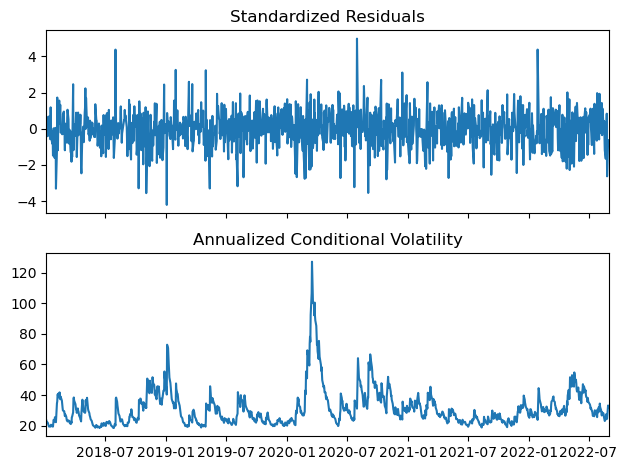

In [10]:
#===== GARCH(1,1) estimates =======================

arch = arch_model(df_train,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
fig = res.plot(annualize='D')
fig.tight_layout()

Looking at this summary, we can conclude the presence of a GARCH(1,1).

**PAUL: Presence of GARCH(1,1) bc the param are signif diff from 0?**
I must review the course maybe but how do you identify or choose the params? Only using the AR(1) optimal param and the presence of GARCH effect ?

## 1-step ahead forecast:

In [11]:
idx = df_test.index
forecasts = []
data_shifted = df.shift(1).loc[idx].apply(np.log)

# estimate all
print('\nforecasting fixed')
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

forecast_arma = arma_model.predict(n_periods=1)[0]

forecast_garch = garch_res.forecast(horizon=1, reindex=False)
predicted_et = forecast_garch.mean['h.1'].iloc[-1]

prediction = forecast_arma + predicted_et
prediction = pd.DataFrame(prediction, columns=['fixed'], index=idx).cumsum()


forecasting fixed
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
  

In [12]:
# ============== recursive window =========================

print('forecasting recursive window')
forecast = []

for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    
    arma_model  = tsa.arima.model.ARIMA(_data, order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=1)[0]
    forecast_garch = garch_res.forecast(horizon=1, reindex=False)
    predicted_et = forecast_garch.mean['h.1'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())

forecast = pd.DataFrame(forecast, columns=['Recursive'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting recursive window
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.469523541744
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53530.82341780863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.0613586163918
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.2360442809377
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529843062
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2375.914997532019
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2375.9149975320215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2375.914997532019
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6239.166393325342
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53508.80969488236
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2636.5118273295316
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2609.3275435430132
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2425.542386225384
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2392.5763962753895
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2392.3956537749086
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2392.3739367633866
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2392.3700812555353
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2392.3694852695003
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2392.3692579068347
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2392.3692579068374
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2392.3692579068347
            Iterat

Iteration:     11,   Func. Count:     80,   Neg. LLF: 2410.344800268547
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2410.344800268549
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2410.344800268547
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6312.770664205392
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54023.178896878395
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2662.600962047347
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2626.7639333762218
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2522.3008499045
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2412.2856895647783
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2412.0911379137324
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2412.068679456438
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2412.0643818100

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6372.9297768514525
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55182.5431684857
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2688.2548976505486
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2646.4369635854505
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2754.4373339156673
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2431.4603481128756
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2431.346926060609
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2431.3316816590986
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2431.3292315921635
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2431.32871088445
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2431.328578922786
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2431.3285783324436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2431.3285783324436
            Iteration

Iteration:      4,   Func. Count:     35,   Neg. LLF: 2671.390842263247
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2553.2851168775705
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2454.4266152361397
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2454.2443313899603
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2454.222139505009
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2454.2172132301193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2454.21645980761
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2454.2162530099827
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2454.216253009983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2454.2162530099827
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6379.538586005714
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56087.073943

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3638.394399828776
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2480.423576871669
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2479.7956585338684
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2479.7803596451404
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2479.7762976628574
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2479.77588122248
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2479.7758640831844
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2479.775864083198
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2479.7758640831844
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6438.255473284427
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55696.31111939804
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2705.31115617

Iteration:      8,   Func. Count:     61,   Neg. LLF: 2496.33254771648
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2496.3272810092194
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2496.3263803140385
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2496.326099548589
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2496.3260985739607
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2496.3260985739607
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6491.103749530887
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54754.318877307254
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2753.2703669326474
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2712.820429711516
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3641.778508267272
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2498.1843154

Iteration:      9,   Func. Count:     67,   Neg. LLF: 2517.350968567942
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2517.350385649048
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2517.350212974082
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2517.3502129740855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2517.350212974082
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6565.3654312669605
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55617.18547246149
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2789.777377901315
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2735.1870655085554
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3679.056593692683
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2519.5268644787016
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2519.35882376

Iteration:      7,   Func. Count:     55,   Neg. LLF: 2538.851483031537
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2538.8189116774747
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2538.8126969547175
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2538.8119523493597
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2538.8117159299854
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2538.811715350721
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2538.811715350721
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12


In [13]:
# =================== rolling window ==================================== 
print('forecasting rolling window\n')
forecast = []
roll_freq = 200
    
for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    arma_model  = tsa.arima.model.ARIMA(_data.iloc[-roll_freq:], order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=1)[0]
    forecast_garch = garch_res.forecast(horizon=1, reindex=False)
    predicted_et = forecast_garch.mean['h.1'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())
    
forecast = pd.DataFrame(forecast, columns=['Rolling'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting rolling window

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.06047170991

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.469523541744
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53530.82341780863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.0613586163918
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.2360442809377
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529843062
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2375.914997532019
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2375.9149975320215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2375.914997532019
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6299.004785368354
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53061.89011322336
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2655.448355097097
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2616.038682883521
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2787.343689729793
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2402.724957728533
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2402.523725809254
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2402.5010794884756
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2402.496620220776
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2402.49595679137
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2402.4957353316618
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2402.495735331663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2402.4957353316618
            Iterations: 12

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6362.7902751401925
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53581.12374767636
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2680.2649314349555
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2638.501126846495
Iteration:      5,   Func. Count:     43,   Neg. LLF: 3070.7636647031745
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2422.748917174179
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2422.558695934
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2422.5384487717884
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2422.5344398288703
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2422.5338363527044
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2422.533640857684
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2422.533640857685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2422.533640857684
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6361.241738797939
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56355.08233092746
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2697.344324986884
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2671.390842263247
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2553.2851168775705
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2454.4266152361397
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2454.2443313899603
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2454.222139505009
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2454.2172132301193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2454.21645980761
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2454.2162530099827
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2454.216253009983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2454.2162530099827
            Iterations:

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3648.1295161914527
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2474.0256241493835
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2473.899718624769
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2473.8853736808796
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2473.88282372197
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2473.882371653175
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2473.882263073493
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2473.8822630734912
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2473.882263073493
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6446.934261996645
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55881.23400087649
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2701.564351066

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3641.778508267272
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2498.1843154140743
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2498.009672102752
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2497.9824226104083
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2497.9769135222946
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2497.9758898734412
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2497.975562076762
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2497.975560878349
Iteration:     13,   Func. Count:     90,   Neg. LLF: 2497.975560878348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2497.975560878349
            Iterations: 13
            Function evaluations: 90
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6505.052419247992
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54816.6846524

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3675.5667397103052
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2517.5512114665044
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2517.377523345058
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2517.355072450851
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2517.350968567942
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2517.350385649048
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2517.350212974082
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2517.3502129740855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2517.350212974082
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6565.3654312669605
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55617.18547246149
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2789.77737790

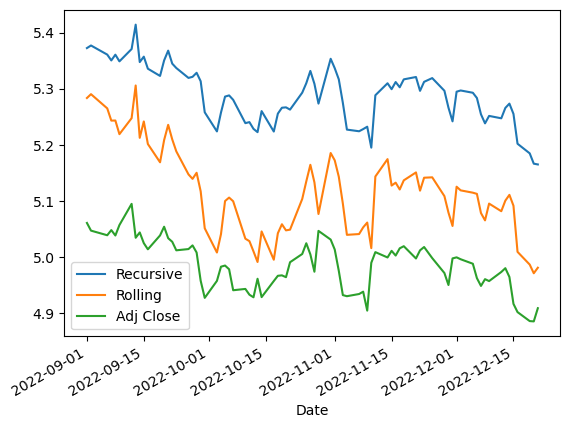


 forecasts 
             Recursive   Rolling
Date                           
2022-09-01   5.372622  5.283546
2022-09-02   5.377236  5.290395
2022-09-06   5.361007  5.265074
2022-09-07   5.350605  5.243247
2022-09-08   5.360835  5.243408
...               ...       ...
2022-12-15   5.255184  5.091391
2022-12-16   5.201973  5.009125
2022-12-19   5.184822  4.986387
2022-12-20   5.166414  4.970939
2022-12-21   5.165025  4.980808

[78 rows x 2 columns]

 MAE 
 Recursive    2.362447
Rolling      1.021278
dtype: float64

 RMSE 
 Recursive    0.849381
Rolling      0.390131
dtype: float64


In [14]:
#=================== plot forecasts and calc error ===========================================================================    
    
forecasts = pd.concat(forecasts, axis=1)
obs = df.loc[df_test.index].apply(np.log)
# plot data and forcasts
output = pd.concat([forecasts, obs], axis=1)
output.plot()
plt.show()
# plot data and forcasts
epsilon = forecasts.sub(obs.squeeze(), axis=0)
    
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecasts)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

## 20-steps ahead forecast:

In [15]:
idx = df_test.index
forecasts = []
data_shifted = df.shift(20).loc[idx].apply(np.log)

# estimate all
print('\nforecasting fixed')
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

forecast_arma = arma_model.predict(n_periods=20)[0]

forecast_garch = garch_res.forecast(horizon=20, reindex=False)
predicted_et = forecast_garch.mean['h.20'].iloc[-1]

prediction = forecast_arma + predicted_et
prediction = pd.DataFrame(prediction, columns=['Fixed'], index=idx).cumsum()


forecasting fixed
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
  

In [16]:
# ============== recursive window ========================= 
print('forecasting recursive window')
forecast = []

for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    
    arma_model  = tsa.arima.model.ARIMA(_data, order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=20)[0]
    forecast_garch = garch_res.forecast(horizon=20, reindex=False)
    predicted_et = forecast_garch.mean['h.20'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())

forecast = pd.DataFrame(forecast, columns=['Recursive'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting recursive window
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.286644266087
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53611.82003391755
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.72013056796
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.127403681735
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.24958167474
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054583386748
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.855042013029
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.829364778261
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.8245000368793
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.8237366121284
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.8234334641243
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.8234334641265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.8234334641243
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6245.817316927369
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53419.411451148524
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2639.963067154923
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2612.841307617851
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2487.202969819906
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2395.5646519109687
Iteration:      7,   Func. Count:     57,   Neg. LLF: 2395.3671091381766
Iteration:      8,   Func. Count:     63,   Neg. LLF: 2395.3632967988033
Iteration:      9,   Func. Count:     69,   Neg. LLF: 2395.3623972322025
Iteration:     10,   Func. Count:     75,   Neg. LLF: 2395.362134144337
Iteration:     11,   Func. Count:     81,   Neg. LLF: 2395.3621296986944
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2395.3621296986894
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2395.3621296986944
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6358.548312682527
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53761.75076712967
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2678.7036598993022
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2635.40988836647
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3562.171103782436
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2421.0479376499
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2420.9191648444103
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2420.9003769413516
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2420.897290920866
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2420.89662331997
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2420.8964345490613
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2420.896433845278
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2420.896433845278
            Iterations: 12
 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6384.271969856934
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55136.389999758365
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.3157886156087
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2657.144916646418
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2486.798461224477
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2439.0610559846928
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2438.859758881758
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2438.835240285334
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2438.83092664413
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2438.830337184328
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2438.830129216183
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2438.8301292161855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2438.830129216183
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6467.103854185144
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56015.59199526579
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2683.2454730249224
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2606.8224439820915
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3630.29484431527
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2465.7650184354716
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2465.1822247163805
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2465.1694162675612
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2465.1669292330653
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2465.1664306194743
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2465.1664226640796
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2465.166422056028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2465.166422056028
            Iteration

Iteration:      4,   Func. Count:     34,   Neg. LLF: 2705.5505204498577
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3636.687537409417
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2488.525949698256
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2488.33149793431
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2488.3057154426224
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2488.30022770726
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2488.2994243110725
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2488.2991728981688
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2488.2991721629614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2488.2991721629614
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6463.681842161649
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55262.4271317

Iteration:      6,   Func. Count:     49,   Neg. LLF: 2509.5930742040305
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2509.4273836984494
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2509.40651359978
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2509.4024036855635
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2509.4018130319564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2509.4016465580826
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2509.4016465580858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2509.4016465580826
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6522.30813185598
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55842.956384218225
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2771.3736021214263
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2727.43771

Iteration:      8,   Func. Count:     61,   Neg. LLF: 2525.9620277145873
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2525.9581642714666
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2525.95750507668
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2525.9572972017268
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2525.9572965917823
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2525.9572965917823
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6585.239756061828
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55397.16076714209
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2803.3799554192556
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2744.410940436135
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3684.209551889609
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2528.2237662

In [17]:
# =================== rolling window ==================================== 
print('forecasting rolling window\n')
forecast = []
roll_freq = 200
    
for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    arma_model  = tsa.arima.model.ARIMA(_data.iloc[-roll_freq:], order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=20)[0]
    forecast_garch = garch_res.forecast(horizon=20, reindex=False)
    predicted_et = forecast_garch.mean['h.20'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())
    
forecast = pd.DataFrame(forecast, columns=['Rolling'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting rolling window

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.06047170991

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.286644266087
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53611.82003391755
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.72013056796
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.127403681735
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.24958167474
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054583386748
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.855042013029
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.829364778261
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.8245000368793
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.8237366121284
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.8234334641243
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.8234334641265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.8234334641243
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6245.817316927369
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53419.411451148524
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2639.963067154923
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2612.841307617851
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2487.202969819906
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2395.5646519109687
Iteration:      7,   Func. Count:     57,   Neg. LLF: 2395.3671091381766
Iteration:      8,   Func. Count:     63,   Neg. LLF: 2395.3632967988033
Iteration:      9,   Func. Count:     69,   Neg. LLF: 2395.3623972322025
Iteration:     10,   Func. Count:     75,   Neg. LLF: 2395.362134144337
Iteration:     11,   Func. Count:     81,   Neg. LLF: 2395.3621296986944
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2395.3621296986894
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2395.3621296986944
            Iteratio

Iteration:     11,   Func. Count:     79,   Neg. LLF: 2417.3555334224416
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2417.355532726352
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2417.355532726352
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6351.039661467841
Iteration:      2,   Func. Count:     17,   Neg. LLF: 52736.15436595081
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2675.914148203426
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2633.9814731055126
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3560.124554915626
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2419.2013908517897
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2419.0726676764816
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2419.053994125603
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2419.05086904

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6387.666015310387
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54463.33066052478
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.401564907676
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2652.856539469685
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2545.5883662883725
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2436.4792391430074
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2436.2788547017117
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2436.255901781861
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2436.2516177485945
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2436.251009329122
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2436.250797921005
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2436.2507979210077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2436.250797921005
            Iterations:

Iteration:     11,   Func. Count:     79,   Neg. LLF: 2461.7935261156135
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2461.7935255414386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2461.7935255414386
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6467.103854185144
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56015.59199526579
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2683.2454730249224
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2606.8224439820915
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3630.29484431527
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2465.7650184354716
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2465.1822247163805
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2465.1694162675612
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2465.16692

Iteration:      6,   Func. Count:     49,   Neg. LLF: 2485.0818820968243
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2484.2479549196064
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2484.232636516183
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2484.2283597763294
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2484.2279596456187
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2484.2279353746767
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2484.227935374681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2484.2279353746767
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6451.741259568644
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55622.03591390703
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2738.4655129003395
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2704.53010

Iteration:     10,   Func. Count:     73,   Neg. LLF: 2500.2880222961935
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2500.2877490891847
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2500.287748114402
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2500.287748114402
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6522.638870771019
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54973.73820627653
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2767.031607868375
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2718.676694703727
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3655.966169786602
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2503.2520179431167
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2503.0867879166744
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2503.06414960

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3677.859147315741
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2522.8136973936357
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2522.6477630641525
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2522.6246967020866
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2522.62071199817
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2522.6200872762674
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2522.619895774369
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2522.6198952050736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2522.6198952050736
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6574.378595818802
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55435.37646544851
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2795.9917479

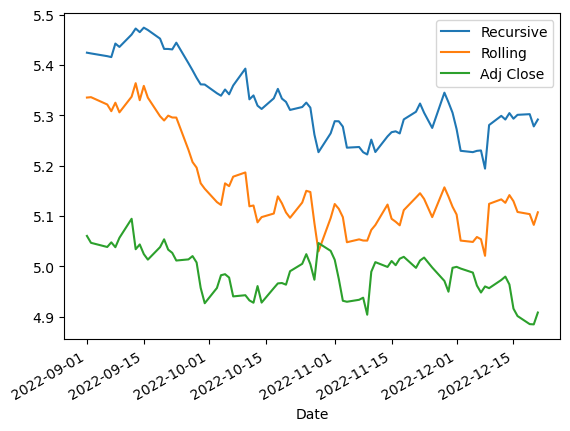


 forecasts 
             Recursive   Rolling
Date                           
2022-09-01   5.424430  5.335355
2022-09-02   5.422959  5.336118
2022-09-06   5.417527  5.321594
2022-09-07   5.415677  5.308319
2022-09-08   5.442553  5.325126
...               ...       ...
2022-12-15   5.293408  5.129615
2022-12-16   5.301072  5.108224
2022-12-19   5.302382  5.103947
2022-12-20   5.278092  5.082617
2022-12-21   5.291787  5.107570

[78 rows x 2 columns]

 MAE 
 Recursive    2.669803
Rolling      1.331938
dtype: float64

 RMSE 
 Recursive    0.972026
Rolling      0.518046
dtype: float64


In [18]:
#===================plot forecasts and calc error ===========================================================================    
    
forecasts = pd.concat(forecasts, axis=1)
obs = df.loc[df_test.index].apply(np.log)
# plot data and forcasts
output = pd.concat([forecasts, obs], axis=1)
output.plot()
plt.show()
# plot data and forcasts
epsilon = forecasts.sub(obs.squeeze(), axis=0)
    
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecasts)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

## VaR computations:

In [19]:
print(t.ppf(0.05,9.4548))
print(norm.ppf(0.05))

-1.8231245366836821
-1.6448536269514729


Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
            Iteration

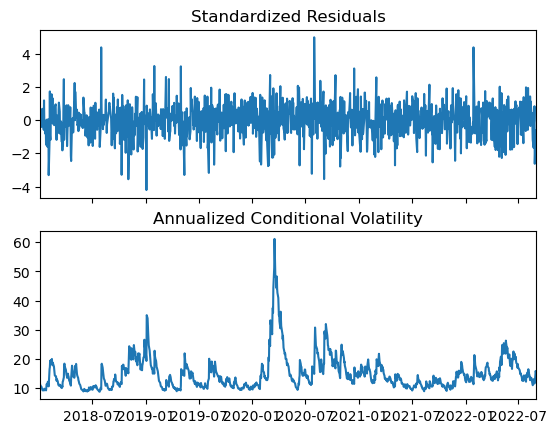

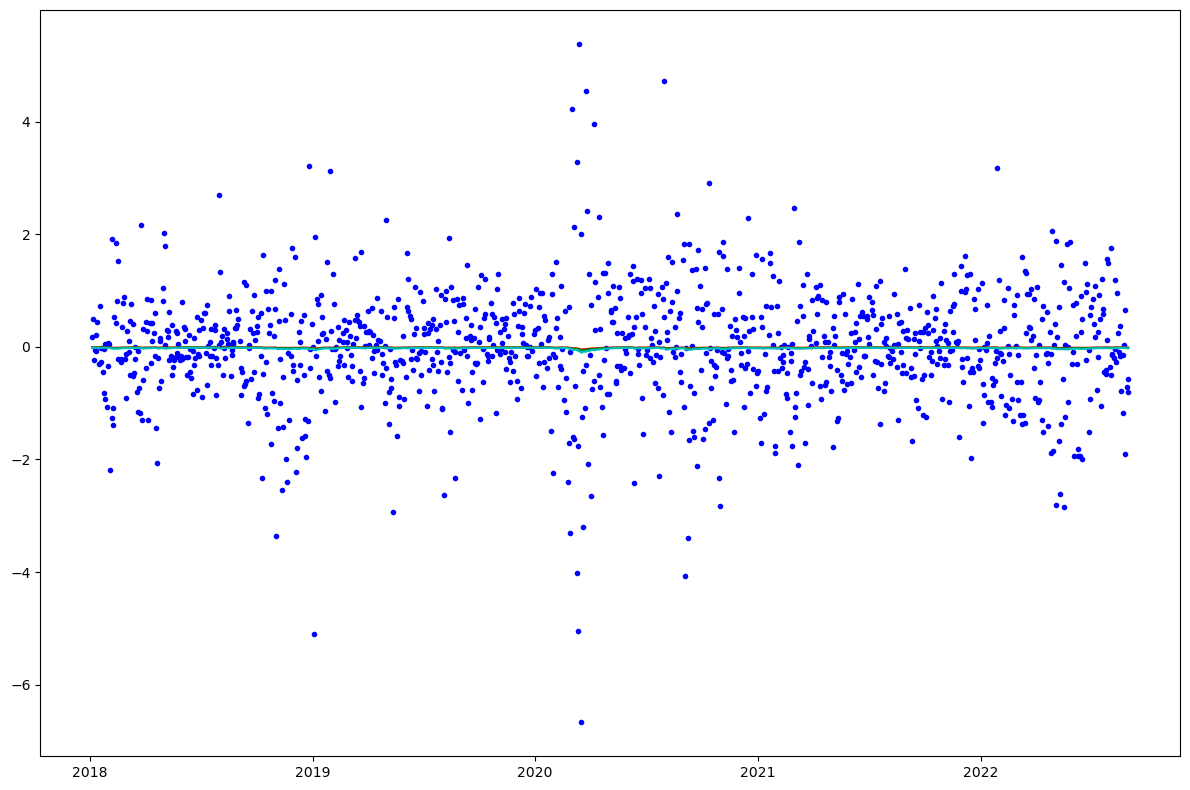

In [20]:
#================== In-sample Value-at-Risk estimates=================

#======= GARCH(1,1) estimates =====================================

arch = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
fig = res.plot(annualize='D')


temp = res.conditional_volatility
var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(df_train_std, 'b.', var90, 'r-', var95, 'g-', var99, 'c-')
plt.tight_layout()
 
print(np.mean(df_train_std < var90))  
print(np.mean(df_train_std < var95)) 
print(np.mean(df_train_std < var99))

**PAUL: Ok donc ici la vol dans les returns est vachement large, on voit à peine la diff entre les différentes VaR. Bon à analyser/commenter.** 

In [31]:
#============= Out-of-sample Value-at-Risk estimates ===========================

# Define 99% VaR study and the size of the out-of-sample study 
alpha = 0.01
oos = 78
nb_obs = len(df_logret)

# Prepare to fill the Out-of-sample VaR's in df
VaR_oss = pd.DataFrame(index=range(0,nb_obs), columns=['VaR_sd','VaR_GARCH','VaR_GJR','VaR_GARCHstd'])

# Loop through the sample to compute each model VaR
for x in range(nb_obs-oos, nb_obs):
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_sd")] = np.std(df_test, axis=0) * norm.ppf(alpha) 
    arch_res = arch_model(df_test,p=1, o=0, q=0, dist='Normal').fit()
    arch_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCH")] = np.sqrt(arch_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    gjr_res = arch_model(df_test,p=1, o=1, q=1, dist='Normal').fit()
    gjr_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GJR")] = np.sqrt(gjr_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    garchSTD_res = arch_model(df_test,p=1, o=0, q=1, dist='t').fit()
    garchSTD_res_forecast = garchSTD_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCHstd")] = np.sqrt(garchSTD_res_forecast.variance.values[-1, 0]) * t.ppf(alpha,garchSTD_res.params[-1])

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1

Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.61579

Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.71327

Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939

Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676

Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 1

Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.71327

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.616476

Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1

Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28


In [33]:
# Visualize the VaR Data -> Idea for the plot
VaR_oss = VaR_oss.dropna()
VaR_oss
# We see that the VaR is constant -> Plot makes sense

,VaR_sd,VaR_GARCH,VaR_GJR,VaR_GARCHstd
1173,-5.786833,-6.072865,-6.072865,-6.408529
1174,-5.786833,-6.072865,-6.072865,-6.408529
1175,-5.786833,-6.072865,-6.072865,-6.408529
1176,-5.786833,-6.072865,-6.072865,-6.408529
1177,-5.786833,-6.072865,-6.072865,-6.408529
...,...,...,...,...
1246,-5.786833,-6.072865,-6.072865,-6.408529
1247,-5.786833,-6.072865,-6.072865,-6.408529
1248,-5.786833,-6.072865,-6.072865,-6.408529
1249,-5.786833,-6.072865,-6.072865,-6.408529


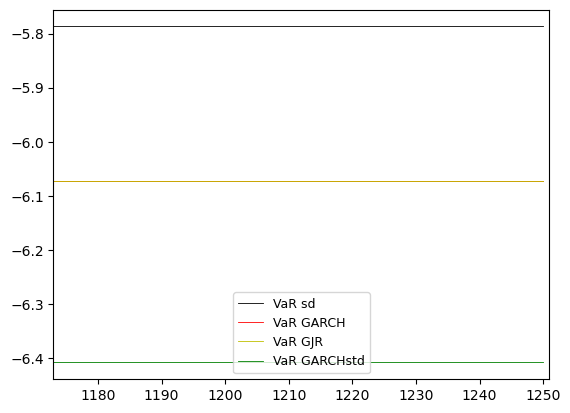

In [32]:
plt.clf()
plt.plot(VaR_oss['VaR_sd'], 'k', label='VaR sd',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCH'], 'r', label='VaR GARCH',linewidth=0.6)
plt.plot(VaR_oss['VaR_GJR'], 'y', label='VaR GJR',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCHstd'], 'g', label='VaR GARCHstd',linewidth=0.6)
plt.xlim(nb_obs-oos, nb_obs)
plt.legend(loc='best', fontsize=9)

In [35]:
#============= In and Out-of-sample Value-at-Risk estimates ===========================

# Compute VaR 90%, 95%, and 99% using quantile method --> Careful in Lab3 Sylvain only focused on 99% VaR
Varin_90 = df_train.quantile(0.1).round(4)
Varin_95 = df_train.quantile(0.05).round(4)
Varin_99 = df_train.quantile(0.01).round(4)
Varout_90 = df_test.quantile(0.1).round(4)
Varout_95 = df_test.quantile(0.05).round(4)
Varout_99 = df_test.quantile(0.01).round(4)

# Check for exceptions
Vin90 = 0
Vin95 = 0
Vin99 = 0
Vout90 = 0
Vout95 = 0
Vout99 = 0
for i in df_train:
    if i < Varin_90:
        Vin90 += 1
    if i < Varin_95:
        Vin95 += 1
    if i < Varin_99:
        Vin99 += 1
for j in df_test:
    if j < Varout_90:
        Vout90 += 1
    if j < Varout_95:
        Vout95 += 1
    if j < Varout_99:
        Vout99 += 1
        
# Prepare dataframe to visualize overall data
CL = ['90%', '95%', '99%']
IS_VAR = [Varin_90, Varin_95, Varin_99]
IS_Excep = [Vin90, Vin95,Vin99]
OOS_VAR = [Varout_90, Varout_95, Varout_99]
OOS_Excep = [Vout90, Vout95,Vout99]
df_VaR = pd.DataFrame.from_dict({ 'Confidence Level': CL,
                                    'In-Sample VaR': IS_VAR,
                                    'In-Sample Exceptions': IS_Excep,
                                    'Out-of-Sample VaR': OOS_VAR,
                                    'In-Sample Exceptions': OOS_Excep,})
df_VaR

,Confidence Level,In-Sample VaR,In-Sample Exceptions,Out-of-Sample VaR
0,90%,-2.2537,8,-3.1489
1,95%,-3.2250,4,-3.8815
2,99%,-5.7418,1,-5.2691
